# CPSC 368 Impact By Disease (KNM Neighbours)

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display

In [11]:
USCDI = pd.read_csv('final_datasets_V1/cleaned/U.S._Chronic_Disease_Indicators_newcols.csv')
KFF2019_new = pd.read_csv("final_datasets_V1/cleaned/KFF2019_new.csv")

In [12]:
USCDI['DataValueUnit'] = USCDI['DataValueUnit'].replace({'cases per 100,000': 'per 100,000'})

In [13]:
print("DataFrame shape:", USCDI.shape)

DataFrame shape: (309215, 13)


In [14]:
USCDI_filter1 = USCDI[
    (USCDI['LocationDesc'].isin(['Texas', 'Massachusetts'])) &
    (USCDI['Topic'].isin(['Cardiovascular Disease', 'Cancer'])) &
    (USCDI['DataValueUnit'] == "per 100,000")&
    (USCDI['DataValueType'] == "Crude Rate") &
    (USCDI["Has2019"] == True)
]

In [48]:
USCDI_filter2 = USCDI_filter1[['Stratification1','Question','LocationDesc', 'Topic', 'DataValueUnit','DataValueType', 'AvgDataValue']]
USCDI_final = pd.merge(USCDI_filter2, KFF2019_new[['Location', 'All_Uninsured']], 
                     left_on='LocationDesc', right_on='Location', how='left')
USCDI_final.drop(columns='Location', inplace=True)
USCDI_final.rename(columns={'AvgDataValue': 'AvgDeathRate'}, inplace=True)
USCDI_final.rename(columns={'DataValueType': 'DeathRateType'}, inplace=True)
USCDI_final.rename(columns={'DataValueUnit': 'DeathRateUnit'}, inplace=True)
USCDI_final.rename(columns={'Topic': 'Disease'}, inplace = True)
USCDI_final.rename(columns={'LocationDesc': 'State'}, inplace = True)

In [17]:
USCDI_final['Question'] = USCDI_final['Question'].replace(
    {'Cervical cancer mortality among all females, underlying cause': 
     'Cervical cancer'})

USCDI_final['Question'] = USCDI_final['Question'].replace(
    {'Invasive cancer (all sites combined) mortality among all people, underlying cause': 
     'Invasive cancer'})

USCDI_final['Question'] = USCDI_final['Question'].replace(
    {'Breast cancer mortality among all females, underlying cause': 
     'Breast cancer'})

USCDI_final['Question'] = USCDI_final['Question'].replace(
    {'Colon and rectum (colorectal) cancer mortality among all people, underlying cause': 
     'Colorectal cancer'})

USCDI_final['Question'] = USCDI_final['Question'].replace(
    {'Lung and bronchial cancer mortality among all people, underlying cause': 
     'Lung cancer'})

USCDI_final['Question'] = USCDI_final['Question'].replace(
    {'Prostate cancer mortality among all males, underlying cause': 
     'Prostate cancer'})

USCDI_final['Question'] = USCDI_final['Question'].replace(
    {'Coronary heart disease mortality among all people, underlying cause': 
     'Coronary heart disease'})

USCDI_final = USCDI_final[USCDI_final['Question'].isin(['Cervical cancer', 'Breast cancer',
                                                        'Colorectal cancer', 'Prostate cancer',
                                                       'Lung cancer', 'Coronary heart disease'])]

USCDI_final.rename(columns={'Question': 'Type'}, inplace=True)

In [43]:
USCDI_final.isnull().sum()

Stratification1    0
Type               0
State              0
Disease            0
DeathRateUnit      0
DeathRateType      0
AvgDeathRate       0
All_Uninsured      0
dtype: int64

In [18]:
USCDI_final['Type'].unique()

array(['Cervical cancer', 'Breast cancer', 'Colorectal cancer',
       'Lung cancer', 'Prostate cancer', 'Coronary heart disease'],
      dtype=object)

In [19]:
CHD = USCDI_final[
    (USCDI_final['Disease'] == "Cardiovascular Disease")]

CANCER = USCDI_final[USCDI_final['Disease'] == "Cancer"]

,Stratification1,Type,State,Disease,DeathRateUnit,DeathRateType,AvgDeathRate,All_Uninsured
0,"Asian or Pacific Islander, non-Hispanic",Cervical cancer,Texas,Cancer,"per 100,000",Crude Rate,0.28,0.245
1,"American Indian or Alaska Native, non-Hispanic",Cervical cancer,Massachusetts,Cancer,"per 100,000",Crude Rate,0.00,0.044
3,Hispanic,Breast cancer,Massachusetts,Cancer,"per 100,000",Crude Rate,1.68,0.044
4,"Black, non-Hispanic",Colorectal cancer,Massachusetts,Cancer,"per 100,000",Crude Rate,2.10,0.044
5,"Black, non-Hispanic",Lung cancer,Massachusetts,Cancer,"per 100,000",Crude Rate,4.08,0.044
...,...,...,...,...,...,...,...,...
218,Male,Cervical cancer,Texas,Cancer,"per 100,000",Crude Rate,0.00,0.245
219,Overall,Cervical cancer,Texas,Cancer,"per 100,000",Crude Rate,0.58,0.245
220,Hispanic,Breast cancer,Texas,Cancer,"per 100,000",Crude Rate,2.30,0.245
221,"Asian or Pacific Islander, non-Hispanic",Colorectal cancer,Texas,Cancer,"per 100,000",Crude Rate,1.42,0.245


In [58]:
Q1 = CHD["AvgDeathRate"].quantile(0.25)  
Q3 = CHD["AvgDeathRate"].quantile(0.75) 
IQR = Q3 - Q1  

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_CHD = CHD[(CHD["AvgDeathRate"] < lower_bound) | (CHD["AvgDeathRate"] > upper_bound)]
display(outliers_CHD)

,Stratification1,Type,State,Disease,DeathRateUnit,DeathRateType,AvgDeathRate,All_Uninsured
234,Age >=65,Coronary heart disease,Massachusetts,Cardiovascular Disease,"per 100,000",Crude Rate,411.2,0.044
300,Age >=65,Coronary heart disease,Texas,Cardiovascular Disease,"per 100,000",Crude Rate,518.1,0.245


In [61]:
CHD = CHD[(CHD["AvgDeathRate"] >= lower_bound) & (CHD["AvgDeathRate"] <= upper_bound)]

In [66]:
CHD.groupby(["State"])["AvgDeathRate"].agg(["mean","std","min","max","count"])

,mean,std,min,max,count
State,,,,,
Massachusetts,42.800,39.094454,0.0,105.8,12
Texas,58.725,43.869789,0.0,138.3,12


In [57]:
Q1 = CANCER["AvgDeathRate"].quantile(0.25)  
Q3 = CANCER["AvgDeathRate"].quantile(0.75) 
IQR = Q3 - Q1  

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_CANCER = CANCER[(CANCER["AvgDeathRate"] < lower_bound) | (CANCER["AvgDeathRate"] > upper_bound)]
display(outliers_CANCER)

,Stratification1,Type,State,Disease,DeathRateUnit,DeathRateType,AvgDeathRate,All_Uninsured
22,"White, non-Hispanic",Lung cancer,Massachusetts,Cancer,"per 100,000",Crude Rate,10.72,0.044
42,"White, non-Hispanic",Lung cancer,Massachusetts,Cancer,"per 100,000",Crude Rate,11.02,0.044
47,Male,Lung cancer,Massachusetts,Cancer,"per 100,000",Crude Rate,9.12,0.044
164,"White, non-Hispanic",Lung cancer,Texas,Cancer,"per 100,000",Crude Rate,10.94,0.245
200,"White, non-Hispanic",Lung cancer,Texas,Cancer,"per 100,000",Crude Rate,10.76,0.245


In [59]:
CANCER = CANCER[(CANCER["AvgDeathRate"] >= lower_bound) & (CANCER["AvgDeathRate"] <= upper_bound)]

In [60]:
CANCER.groupby(["State","Type"])["AvgDeathRate"].agg(["mean","std","min","max","count"])

mean       std   min    max  count
State         Type                                                    
Massachusetts Breast cancer      2.67750  2.061079  0.00   5.32     16
              Cervical cancer    0.21625  0.135690  0.00   0.40     16
              Colorectal cancer  1.96875  1.159355  0.00   3.36     16
              Lung cancer        6.09875  3.594206  0.00  11.02     16
              Prostate cancer    2.27875  1.886534  0.00   4.54     16
Texas         Breast cancer      3.21250  1.984270  0.00   5.88     16
              Cervical cancer    0.41500  0.272127  0.00   0.72     16
              Colorectal cancer  2.42375  0.931757  1.04   3.80     16
              Lung cancer        5.41625  2.855967  1.82  10.94     16
              Prostate cancer    1.93125  1.607598  0.00   4.20     16

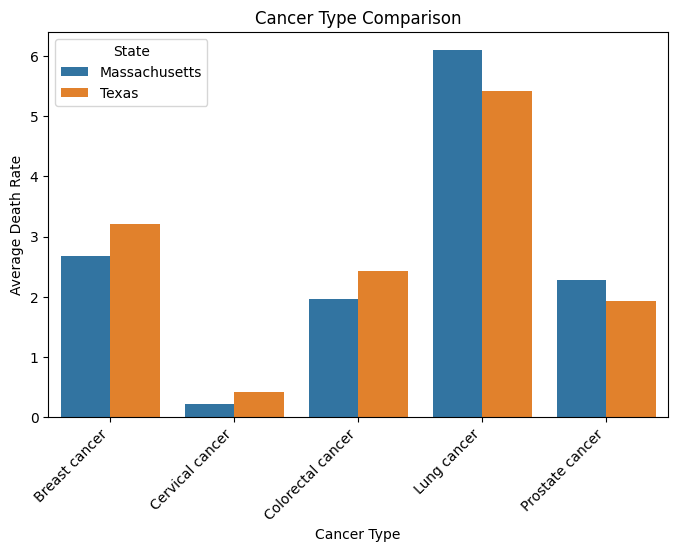

In [63]:
eda_summary_cancer = CANCER.groupby(['State', 'Type'])['AvgDeathRate'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=eda_summary, x='Type', y='AvgDeathRate', hue='State')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Cancer Type')
plt.ylabel('Average Death Rate')
plt.title('Cancer Type Comparison')
plt.legend(title='State')
plt.show()

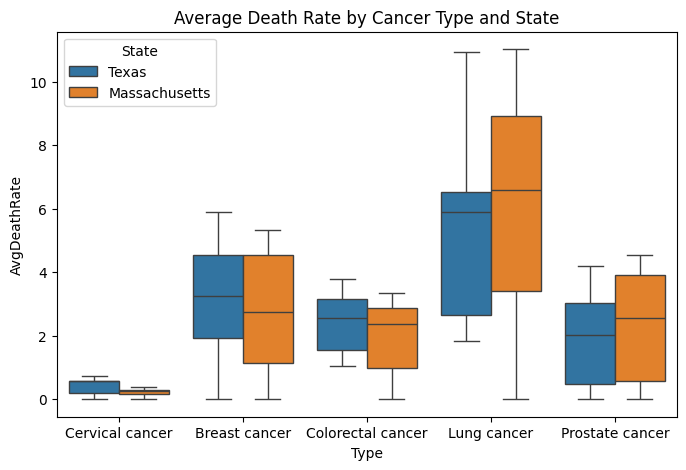

In [64]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=CANCER, x='Type', y='AvgDeathRate', hue='State')
plt.title("Average Death Rate by Cancer Type and State")
plt.show()

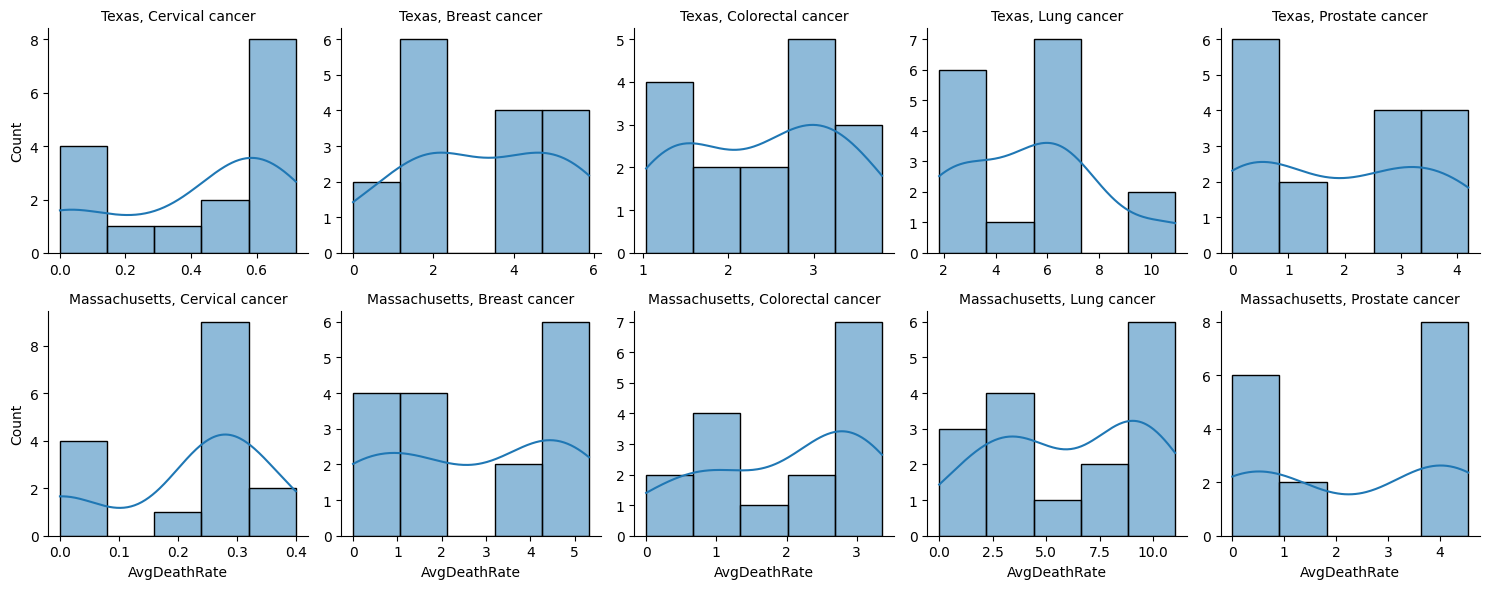

In [65]:
g = sns.FacetGrid(data= CANCER, row = "State", col="Type", height=3, sharex=False, sharey=False)
g.map(sns.histplot, "AvgDeathRate", kde=True)

g.set_titles("{row_name}, {col_name}")
g.set_axis_labels("AvgDeathRate", "Count")
plt.tight_layout()
plt.show()

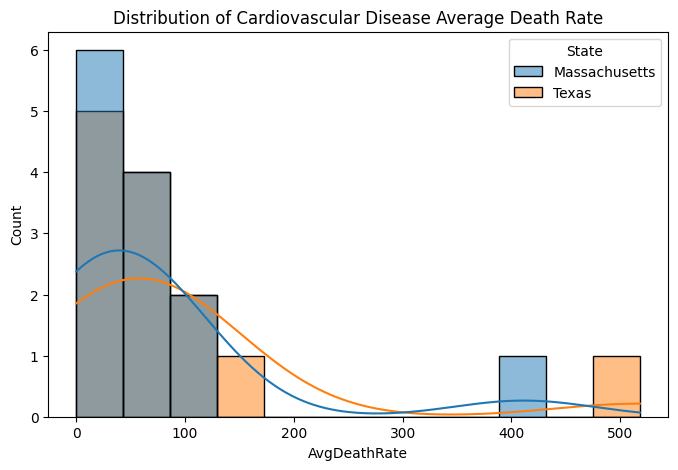

In [23]:
plt.figure(figsize=(8, 5))
sns.histplot(data= CHD, x='AvgDeathRate', hue='State', kde=True)
plt.title("Distribution of Cardiovascular Disease Average Death Rate")
plt.show()